# Predicting Football Results with a Simple Poisson Distribution

This notebook will go through the process of predicting the result of football matches using the (overly-simplistic) Poisson distribution.

This closely follows the work of [David Sheehan](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/) (with corresponding GitHub [here](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-06-04-predicting-football-results-with-statistical-modelling.ipynb)) and [Benedikt Droste](https://towardsdatascience.com/predict-soccer-matches-with-50-accuracy-a24cc8078877).

Another very useful resource on the Poisson distribution in general is this piece by [Will Koehrsen](https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459).

This simple model is based on the number of goals scored and conceded by each team.

Start by importing the data. Here the Premier League 2016/17 season is used.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

epl_1617 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617 = epl_1617[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl_1617 = epl_1617.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1617.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Burnley,Swansea,0,1
1,Crystal Palace,West Brom,0,1
2,Everton,Tottenham,1,1
3,Hull,Leicester,2,1
4,Man City,Sunderland,2,1


With the aim of modelling the final round of fixtures (last 10 games) the last 10 rows (games) must be removed.

In [2]:
epl_1617 = epl_1617[:-10]
epl_1617.mean()

HomeGoals    1.591892
AwayGoals    1.183784
dtype: float64

Instantly, by taking the mean, we see that home teams score more goals than away teams.

## Poisson Distribution

The Poisson distribution is a *discrete* probability distribution describing the probability of the number of events in a specific time period where the *average time* between events is known (the *rate*), but the exact timing of events is random. It is defined (its probability mass function (pmf))
\begin{equation}
    P(k) = e^{-\lambda} \frac{\lambda^k}{k!}\, ,
\end{equation}
where $P(k)$ is the probability of observing $k$ events in a time period and $\lambda$ is the *rate* (expected number of events in an interval). The distribution is always peaked at $\lambda$.

Crucially, the Poisson distribution relies on **three key assumptions**:
1. Events are **independent** of each other. That is, the occurrence of one event does not affect the probability another event will occur.
2. The average rate $\lambda$ is **constant**.
3. Two events **cannot** occur at the same time.

Given these assumptions we can already see some issues:
- Clearly a team scoring a goal affects the probability of another being scored - tactics and mentalities will change. **Gamestate matters** and the first assumption is not true.

To begin, the home and away team will be treated as two separate Poisson distributions given the differences in scoring.

In [3]:
# Calculate Poisson for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(goals,epl_1617.mean()[mean]) for goals in range(8)] for mean in range(2)])

The predictions of these Poisson distributions can then be compared to the distribution of the actual number of goals scored by the home and away teams.

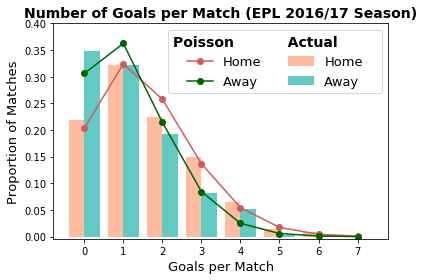

In [4]:
# Plot histogram of actual goals
plt.hist(epl_1617[['HomeGoals', 'AwayGoals']].values, range(9), alpha=0.7, label=['Home', 'Away'],
         density=True, color=["#FFA07A", "#20B2AA"])

# Add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

With these models in hand we can now predict the probability of specific events, e.g. Prob of the home team scoring 2 or more goals?

In [5]:
print(poisson_pred[0,0])
print(poisson_pred[1,0])

0.20354017124365964
0.324013948277069


\begin{align}
    P(\geq 2|\text{Home}) &= 1 - ( P(1|\text{Home}) + P(0|\text{Home}) ) \\
    &= 1 - (0.20 + 0.32)\\
    &= 0.47
\end{align}

E.g. Prob of draw?

\begin{align}
    P(\text{Draw}) &= P(0|\text{Home})\times P(0|\text{Away}) + P(1|\text{Home})\times P(1|\text{Away}) + \ldots \\
    &= 0.248\\
\end{align}

An alternative method of calculating the probability of a draw is to use the difference between the distributions - this is a distribution known as a *Skellam distribution*. For a draw the difference in scoreline between home and away must be 0:

In [6]:
# Prob of draw between home and away team
skellam.pmf(0, epl_1617.mean()[0], epl_1617.mean()[1])

0.24809376810717076

In [7]:
# Prob of home team winning by one goal
skellam.pmf(1, epl_1617.mean()[0], epl_1617.mean()[1])

0.22706765807563964

In [8]:
# Prob of away team winning by one goal
skellam.pmf(-1, epl_1617.mean()[0], epl_1617.mean()[1])

0.16885506661651978

Compare the predicted difference in goals scored to actual.

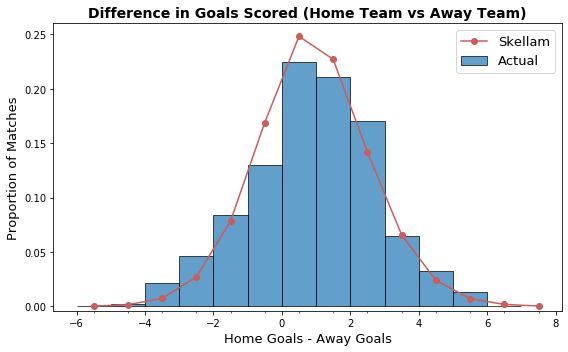

In [9]:
skellam_pred = [skellam.pmf(i,  epl_1617.mean()[0],  epl_1617.mean()[1]) for i in range(-6,8)]

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(epl_1617[['HomeGoals']].values - epl_1617[['AwayGoals']].values, range(-6,8), 
         alpha=0.7, label='Actual',density=True, edgecolor='black')
ax.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
ax.legend(loc='upper right', fontsize=13)
ax.set_xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
ax.set_xlabel("Home Goals - Away Goals",size=13)
ax.set_ylabel("Proportion of Matches",size=13)
ax.set_title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
ax.set_ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()

## Focusing on specific teams

As a case study, look at the distribution of goals scored by Chelsea (top team) and Sunderland (bottom team).

In [10]:
# Find the normalised number of goals scored at home
chel_home = epl_1617[epl_1617['HomeTeam'] == 'Chelsea']['HomeGoals'].value_counts(normalize=True)
sun_home = epl_1617[epl_1617['HomeTeam'] == 'Sunderland']['HomeGoals'].value_counts(normalize=True)

# Calculate the Poisson dists at home
chel_home_pois = [poisson.pmf(i, sum(chel_home.index * chel_home.values)) for i in range(8)]
sun_home_pois = [poisson.pmf(i, sum(sun_home.index * sun_home.values)) for i in range(8)]

# Find the normalised number of goals scored away
chel_away = epl_1617[epl_1617['AwayTeam'] == 'Chelsea']['AwayGoals'].value_counts(normalize=True)
sun_away = epl_1617[epl_1617['AwayTeam'] == 'Sunderland']['AwayGoals'].value_counts(normalize=True)

# Calculate the Poisson dists at home
chel_away_pois = [poisson.pmf(i, sum(chel_away.index * chel_away.values)) for i in range(8)]
sun_away_pois = [poisson.pmf(i, sum(sun_away.index * sun_away.values)) for i in range(8)]

Plot the distributions.

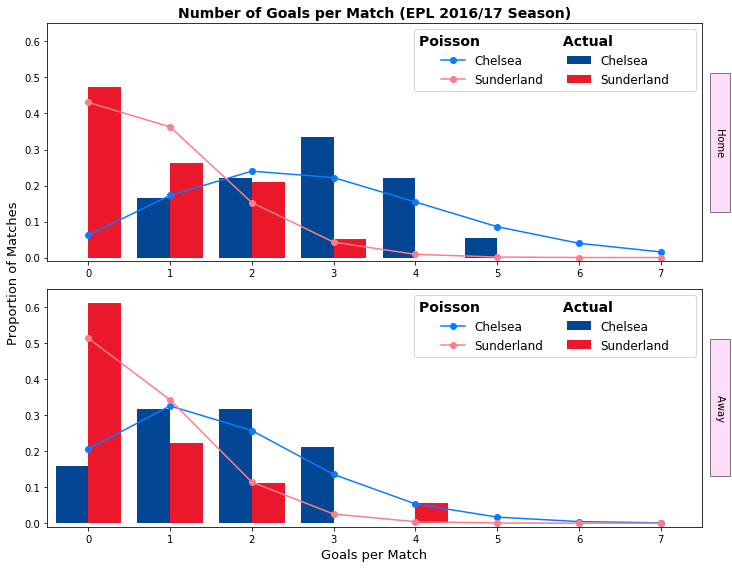

In [11]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,8))

width=0.4

# Home numbers
ax1.bar(chel_home.index - (width/2), chel_home.values, width=width, color="#034694",label="Chelsea")
ax1.bar(sun_home.index + (width/2), sun_home.values, width=width, color="#EB172B",label="Sunderland")
ax1.plot([i for i in range(8)], chel_home_pois, linestyle='-', marker='o',label="Chelsea", color = "#0a7bff")
ax1.plot([i for i in range(8)], sun_home_pois, linestyle='-', marker='o',label="Sunderland", color = "#ff7c89")

leg=ax1.legend(loc='upper right', fontsize=12, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':'14', 'weight':'bold'})
ax1.set_xlim([-0.5,7.5])
ax1.set_ylim([-0.01,0.65])

# Away numbers
ax2.bar(chel_away.index - (width/2), chel_away.values, width=width, color="#034694",label="Chelsea")
ax2.bar(sun_away.index + (width/2), sun_away.values, width=width, color="#EB172B",label="Sunderland")
ax2.plot([i for i in range(8)], chel_away_pois, linestyle='-', marker='o',label="Chelsea", color = "#0a7bff")
ax2.plot([i for i in range(8)], sun_away_pois, linestyle='-', marker='o',label="Sunderland", color = "#ff7c89")

leg=ax2.legend(loc='upper right', fontsize=12, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':'14', 'weight':'bold'})
ax2.set_xlim([-0.5,7.5])
ax2.set_ylim([-0.01,0.65])

# mimicing the facet plots in ggplot2 with a bit of a hack
ax1.text(1.02, 0.5, '                Home                ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5}, va='center', transform=ax1.transAxes)
ax2.text(1.02, 0.5, '                Away                ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5}, va='center', transform=ax2.transAxes)

ax1.set_title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')
ax2.set_xlabel("Goals per Match",size=13)
fig.text(0, 0.4, 'Proportion of Matches', rotation=90, size=13, ha='center')
plt.tight_layout()

plt.show()

## Building a Model

Build a general Poisson regression model. However, remember for each team we only have 19 games.

In [12]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

Create model by separating each match into 2 separate entries, a home entry for the home team and a corresponding away entry.

In [13]:
goal_model_data = pd.concat([epl_1617[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
         epl_1617[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})],
                           ignore_index=True)

goal_model_data.head()

,team,opponent,goals,home
0,Burnley,Swansea,0,1
1,Crystal Palace,West Brom,0,1
2,Everton,Tottenham,1,1
3,Hull,Leicester,2,1
4,Man City,Sunderland,2,1


In [14]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1042.4
Date:                Tue, 21 Apr 2020   Deviance:                       776.11
Time:                        10:57:56   Pearson chi2:                     659.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3725      0.198      1.880      0.060      -0.016       0.761
team[T.Bournemouth]           -0.2891      0.179     -1.612      0.107      -0.641       0.062
team[T.Burnley]               -0.6458      0.200     -3.230      0.001      -1.038      -0.254
team[T.Chelsea]                0.0789      0.162      0.488      0.626      -0.238       0.396
team[T.Crystal Palace]        -0.3865      0.183     -2.107      0.035      -0.746      -0.027
team[T.Everton]               -0.2008      0.173     -1.161      0.246      -0.540       0.138
team[T.Hull]                  -0.7006      0.204     -3.441      0.001      -1.100      -0.302
team[T.Leicester]             -0.4204      0.187     -2.249      0.025      -0.787      -0.054
team[T.Liverpool]              0.0162      0.164      0.099      0.921      -0.306       0.338
team[T.Man City]               0.0117      0.164      0.072      0.943      -0.310       0.334
team[T.Man United]            -0.3572      0.181     -1.971      0.049      -0.713      -0.002
team[T.Middlesbrough]         -1.0087      0.225     -4.481      0.000      -1.450      -0.568
team[T.Southampton]           -0.5804      0.195     -2.976      0.003      -0.963      -0.198
team[T.Stoke]                 -0.6082      0.197     -3.094      0.002      -0.994      -0.223
team[T.Sunderland]            -0.9619      0.222     -4.329      0.000      -1.397      -0.526
team[T.Swansea]               -0.5136      0.192     -2.673      0.008      -0.890      -0.137
team[T.Tottenham]              0.0532      0.162      0.328      0.743      -0.265       0.371
team[T.Watford]               -0.5969      0.197     -3.035      0.002      -0.982      -0.211
team[T.West Brom]             -0.5567      0.194     -2.876      0.004      -0.936      -0.177
team[T.West Ham]              -0.4802      0.189     -2.535      0.011      -0.851      -0.109
opponent[T.Bournemouth]        0.4109      0.196      2.092      0.036       0.026       0.796
opponent[T.Burnley]            0.1657      0.206      0.806      0.420      -0.237       0.569
opponent[T.Chelsea]           -0.3036      0.234     -1.298      0.194      -0.762       0.155
opponent[T.Crystal Palace]     0.3287      0.200      1.647      0.100      -0.062       0.720
opponent[T.Everton]           -0.0442      0.218     -0.202      0.840      -0.472       0.384
opponent[T.Hull]               0.4979      0.193      2.585      0.010       0.120       0.875
opponent[T.Leicester]          0.3369      0.199      1.694      0.090      -0.053       0.727
opponent[T.Liverpool]         -0.0374      0.217     -0.172      0.863      -0.463       0.389
opponent[T.Man City]          -0.0993      0.222     -0.448      0.654      -0.534       0.335
opponent[T.Man United]        -0.4220      

With Poisson regression (like logistic regression) it is the exponent of the parameter values that are the true relevant values. Therefore, large positive value implies more goals $(x>0,\, e^x>1)$, values close to zero represent a close to average effect $(x=0,\, e^x=1)$, and large negative values imply fewer goals $(x<0,\, e^x<1)$.

*home* (at the bottom) shows the advantage home teams have in scoring goals, $x=0.297 \rightarrow e^{0.297}=1.346$ times more likely.

*team* shows how likely that team is to score. Chelsea 0.0789 and Sunderland -0.9619 shows how the former (latter) are better (worse) at scoring than the average.

*opponent* on the other hand shows how easy it is to score against that team. Chelsea -0.3036 and Sunderland 0.3707 shows how the former (latter) conceeds fewer (more) goals than the average.

Now we can make predictions. Simply give the model *team*, *opponent* and *home* (whether *team* is the home team or away team) to see how many goals we expect *team* to score against *opponent*.

Let's predict Chelsea vs Sunderland. First, how many do we expect Chelsea to score?

In [15]:
poisson_model.predict( pd.DataFrame(data={'team':'Chelsea', 'opponent':'Sunderland', 'home':1}, index=[0]) ).values

array([3.06166192])

This is simply the same as doing the calculation
\begin{align}
e^{\text{Intercept} + \text{team} + \text{opponent} + \text{home}}\ .
\end{align}

In [16]:
2.718**(0.3725 + 0.0789 + 0.3707 + 0.2969)

3.0614356643704093

So we expect Chelsea to score 3 goals. Now predict how many Sunderland will score.

In [17]:
poisson_model.predict( pd.DataFrame(data={'team':'Sunderland', 'opponent':'Chelsea', 'home':0}, index=[0]) ).values

array([0.40937279])

So we expect Sunderland to score 0 goals.

As before we have two Poisson distributions. Let's define a function to calculate the probability of various scorelines for any combination of *team*, *opponent* and *home*.

In [18]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    # Find most likely goals scored
    home_goals_avg = foot_model.predict( pd.DataFrame(data={'team':homeTeam, 'opponent':awayTeam, 'home':1}, index=[0]) ).values[0]
    away_goals_avg = foot_model.predict( pd.DataFrame(data={'team':awayTeam, 'opponent':homeTeam, 'home':0}, index=[0]) ).values[0]
    
    # Find probabilities of each team scoring different number of goals
    team_pred = [[poisson.pmf(i, team_avg) for i in range(max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    
    # Calculate matrix of probabilities for different scorelines using outer product of the home and away vectors
    probs = np.outer( np.array(team_pred[0]), np.array(team_pred[1]) )
    return probs

In [19]:
simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=3)

array([[0.03108485, 0.01272529, 0.00260469, 0.00035543],
       [0.0951713 , 0.03896054, 0.00797469, 0.00108821],
       [0.14569118, 0.059642  , 0.01220791, 0.00166586],
       [0.14868571, 0.06086788, 0.01245883, 0.0017001 ]])

This is a matrix showing the probabilities for different scorelines, with the corresponding scorelines
\begin{pmatrix}
0:0 & 0:1 & 0:2 & 0:3 \\
1:0 & 1:1 & 1:2 & 1:3 \\
2:0 & 2:1 & 2:2 & 2:3 \\
3:0 & 3:1 & 3:2 & 3:3
\end{pmatrix}
where the rows are the Chelsea score and the columns correspond to Sunderland score.

With this form it is easy to use matrix manipulation functions to calculate probability of different outcomes.

In [20]:
chel_sun = simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=10)

First, a Chelsea win is given by summing all the entries below the diagonal.

In [21]:
# np.tril is used to select entries below diagonal 
np.sum(np.tril(chel_sun,-1))

0.8885986612364136

Second, a draw.

In [22]:
np.trace(chel_sun)

0.08409349268649574

Finally, a Sunderland win.

In [23]:
# np.triu is used to select entries above diagonal
np.sum(np.triu(chel_sun,1))

0.026961819942852967

## Predicting the final Gameweek

Using the Poisson model the results for the final gameweek can now be predicted.

In [32]:
epl_1617_final = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617_final = epl_1617_final[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl_1617_final = epl_1617_final.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1617_final = epl_1617_final[370:]
epl_1617_final

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
370,Arsenal,Everton,3,1
371,Burnley,West Ham,1,2
372,Chelsea,Sunderland,5,1
373,Hull,Tottenham,1,7
374,Leicester,Bournemouth,1,1
375,Liverpool,Middlesbrough,3,0
376,Man United,Crystal Palace,2,0
377,Southampton,Stoke,0,1
378,Swansea,West Brom,2,1
379,Watford,Man City,0,5


First define a function that returns the most likely home and away goals scored.

In [48]:
def predict_scoreline(foot_model, homeTeam, awayTeam):
    home_goals_avg = foot_model.predict( pd.DataFrame(data={'team':homeTeam, 'opponent':awayTeam, 'home':1}, index=[0]) ).values[0]
    away_goals_avg = foot_model.predict( pd.DataFrame(data={'team':awayTeam, 'opponent':homeTeam, 'home':0}, index=[0]) ).values[0]
    
    return home_goals_avg, away_goals_avg

Calculate the predicted scored goals for each team and add them to the dataframe.

In [80]:
home_pred_list = []
away_pred_list = []
for i in range(len(epl_1617_final)):
    home_pred = predict_scoreline(poisson_model, epl_1617_final['HomeTeam'].values[i], epl_1617_final['AwayTeam'].values[i])[0]
    away_pred = predict_scoreline(poisson_model, epl_1617_final['HomeTeam'].values[i], epl_1617_final['AwayTeam'].values[i])[1]
    home_pred = np.int(np.around(home_pred))
    away_pred = np.int(np.around(away_pred))
    
    home_pred_list.append(home_pred)
    away_pred_list.append(away_pred)
    
epl_1617_final['HomePred'] = home_pred_list
epl_1617_final['AwayPred'] = away_pred_list

Add columns showing whether home (H), away (A) or draw (D) is the outcome for the actual result and predicted. Them check if the predicted result (not scoreline) was correct.

In [81]:
epl_1617_final.loc[(epl_1617_final['HomeGoals'] > epl_1617_final['AwayGoals']), 'Result'] = 'H'
epl_1617_final.loc[(epl_1617_final['HomeGoals'] == epl_1617_final['AwayGoals']), 'Result'] = 'D'
epl_1617_final.loc[(epl_1617_final['HomeGoals'] < epl_1617_final['AwayGoals']), 'Result'] = 'A'

epl_1617_final.loc[(epl_1617_final['HomePred'] > epl_1617_final['AwayPred']), 'Pred'] = 'H'
epl_1617_final.loc[(epl_1617_final['HomePred'] == epl_1617_final['AwayPred']), 'Pred'] = 'D'
epl_1617_final.loc[(epl_1617_final['HomePred'] < epl_1617_final['AwayPred']), 'Pred'] = 'A'

epl_1617_final.loc[(epl_1617_final['Result'] == epl_1617_final['Pred']), 'Correct'] = 'Yes'
epl_1617_final.loc[(epl_1617_final['Result'] != epl_1617_final['Pred']), 'Correct'] = 'No'

In [82]:
epl_1617_final

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomePred,AwayPred,Result,Pred,Correct
370,Arsenal,Everton,3,1,2,1,H,H,Yes
371,Burnley,West Ham,1,2,1,1,A,D,No
372,Chelsea,Sunderland,5,1,3,0,H,H,Yes
373,Hull,Tottenham,1,7,1,3,A,A,Yes
374,Leicester,Bournemouth,1,1,2,2,D,D,Yes
375,Liverpool,Middlesbrough,3,0,2,1,H,H,Yes
376,Man United,Crystal Palace,2,0,2,1,H,H,Yes
377,Southampton,Stoke,0,1,1,1,A,D,No
378,Swansea,West Brom,2,1,1,1,H,D,No
379,Watford,Man City,0,5,1,2,A,A,Yes


Now calculate the actual probabilities for the different outcomes of each match.

In [83]:
def predict_match_outcome(foot_model, homeTeam, awayTeam):
    probs = simulate_match(foot_model, homeTeam, awayTeam, max_goals=10)
    
    home = np.sum(np.tril(probs,-1))
    draw = np.trace(probs)
    away = np.sum(np.triu(probs,1))
    
    result = np.array([home,draw,away])
    
    return result

In [97]:
home_probs = []
draw_probs = []
away_probs = []
for i in range(len(epl_1617_final)):
    probs = predict_match_outcome(poisson_model, epl_1617_final['HomeTeam'].values[i], epl_1617_final['AwayTeam'].values[i])
    
    home_probs.append(probs[0])
    draw_probs.append(probs[1])
    away_probs.append(probs[2])
    
epl_1617_final['HomeProb'] = home_probs
epl_1617_final['DrawProb'] = draw_probs
epl_1617_final['AwayProb'] = away_probs

In [98]:
epl_1617_final

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomePred,AwayPred,Result,Pred,Correct,HomeProb,DrawProb,AwayProb
370,Arsenal,Everton,3,1,2,1,H,H,Yes,0.533001,0.225918,0.241077
371,Burnley,West Ham,1,2,1,1,A,D,No,0.460841,0.263152,0.276006
372,Chelsea,Sunderland,5,1,3,0,H,H,Yes,0.888599,0.084093,0.026962
373,Hull,Tottenham,1,7,1,3,A,A,Yes,0.062653,0.138042,0.799239
374,Leicester,Bournemouth,1,1,2,2,D,D,Yes,0.474692,0.219747,0.305554
375,Liverpool,Middlesbrough,3,0,2,1,H,H,Yes,0.769684,0.160951,0.069341
376,Man United,Crystal Palace,2,0,2,1,H,H,Yes,0.672432,0.208757,0.118805
377,Southampton,Stoke,0,1,1,1,A,D,No,0.496391,0.277415,0.226194
378,Swansea,West Brom,2,1,1,1,H,D,No,0.368164,0.265662,0.366175
379,Watford,Man City,0,5,1,2,A,A,Yes,0.166696,0.202521,0.630770


## Improving the model

As discussed near the beginning of this notebook, the Poisson model relies on a number of assumptions, some of which are broken in predicting football. Here are a few things that could be considered to improve the model:
- Are more goals scored in certain periods of the game, e.g. near the end of each half? A basic attempt at this could look at first half and second half scorelines and see if more goals are scored, on average, in a particular half.
- The impact of gamestate on scoring.
- Including the form of the teams.
- Using a more complex model than Poisson.